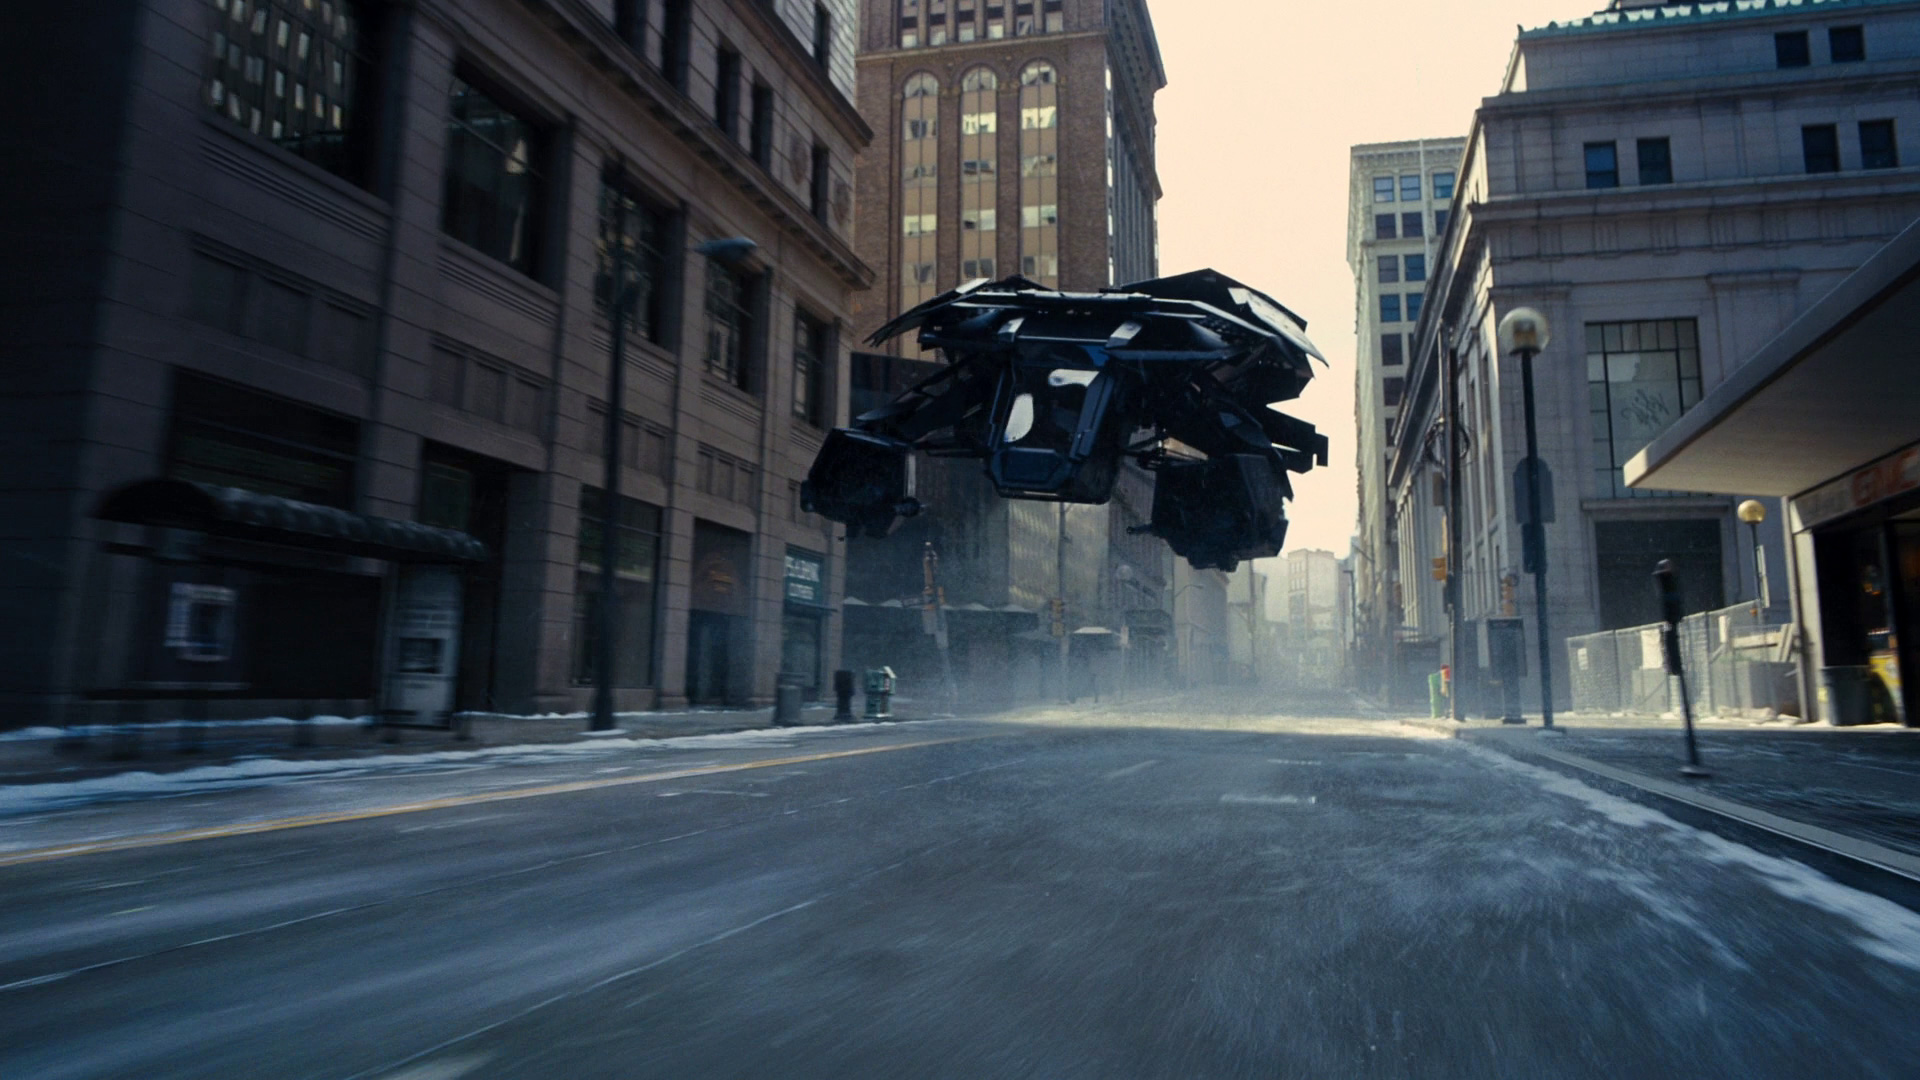

# Проект 8. Возьмёте Бэтмобиль?

**Цель проекта** Создать мультимодель, сочетающую различные подходы машинного и глубокого обучения и разнообразные данные (признаковые, текстовые, изображения), чтобы как можно лучше и точнее предсказать по совокупности входных данных цену машины.

Основано на: Baseline [SF-DST Car Price part2] v6

## 1. Импорт библиотек и ключевые параметры

In [1]:
!pip install --upgrade pip
!pip install -q tensorflow==2.3
!pip install -q albumentations
!pip install -q pymorphy2
!pip install -q pymorphy2-dicts

     |████████████████████████████████| 1.5 MB 2.9 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.2
    Uninstalling pip-20.2.2:
      Successfully uninstalled pip-20.2.2
distutils: /opt/conda/include/python3.7m/UNKNOWN
sysconfig: /opt/conda/include/python3.7m
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.7m/UNKNOWN
sysconfig: /opt/conda/include/python3.7m
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.7m/UNKNOWN
sysconfig: /opt/conda/include/python3.7m
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.7m/UNKNOWN
sysconfig: /opt/conda/include/python3.7m
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.7m/UNKNOWN
sysconfig: /opt/conda/include/python3.7m
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.7m/UNKNOWN
sysconfig: /opt/conda/include/pytho

In [2]:
import random
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import pymorphy2
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import albumentations
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline


print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [3]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [4]:
# Фиксируем RANDOM_SEED для воспроизводимости результатов.
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

TEST_SIZE = 0.15

In [5]:
!pip freeze > requirements.txt

---
## 2. Загрузка и осмотр данных

In [6]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'

train = pd.read_csv(DATA_DIR + 'train.csv')

test = pd.read_csv(DATA_DIR + 'test.csv')

sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [7]:
train.sample(5)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
4280,седан,BMW,серый,ID: 38742\n«МБ Измайлово» – официальный диле...,2.0 LTR,136 N12,бензин,241251,2008,3ER,...,539000.0,2011,1099684586,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,задний,Левый
5975,седан,AUDI,коричневый,Продаю свой авто в связи с крайне редким испол...,1.8 LTR,120 N12,бензин,55000,2011,A4,...,950000.0,2014,1093102394,SEDAN VARIATOR 1.8,вариатор,2 владельца,NaN,Оригинал,передний,Левый
1452,внедорожник 5 дв.,AUDI,коричневый,"Автомобиль в идеальном состоянии не битый, не ...",2.0 LTR,225 N12,бензин,140135,2012,Q5,...,1050000.0,2013,1091088088,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,2 владельца,1 год и 11 месяцев,Оригинал,полный,Левый
5926,седан,AUDI,чёрный,На отличном ходу. В хорошем состоянии для 12 л...,2.4 LTR,177 N12,бензин,236000,2004,A6,...,460000.0,2008,1098822638,SEDAN VARIATOR 2.4,вариатор,3 или более,8 лет и 9 месяцев,Оригинал,передний,Левый
6069,внедорожник 5 дв.,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,1.6 LTR,156 N12,бензин,57902,2013,GLA_CLASS,...,1261000.0,2014,1100155472,ALLROAD_5_DOORS ROBOT 1.6,роботизированная,1 владелец,NaN,Оригинал,передний,Левый


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [9]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

---
## 3. Модель №1 - "Наивный" подход 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [10]:
data_train, data_test = train_test_split(train, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [11]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


**Вывод**

При использовании простых медиан по модели и году выпуска мы получили MAPE 19.88% 

---
## 4. Первичная предобработка данных

Проведем анализ входных данных и подготовим их для моделей.

In [12]:
def categorical_eda(data, feature):
    '''
    Функция, проводящая стандартизированный анализ категориальных признаков.
    '''
    if feature in data.columns:
    
        # Выведем топовые значения в процентном соотношении

        vc = data[feature].value_counts(normalize=True, dropna=False).round(3)

        if len(vc) <= 10:
            vc_adj = vc
        else:
            vc_adj = vc.iloc[:10]
            vc_adj['other'] = 1 - sum(vc.iloc[:10])

        print(vc_adj)
        
        print(f'Кол-во пропусков: {len(data[data[feature].isna()])}')
        
    else:
        print(f'Признак {feature} не найден.')
        
    return None

In [13]:
def numerical_eda(data, feature):
    '''
    Функция, проводящая стандартизированный анализ числовых признаков.
    '''
    # Выводим описательные статистики переменной
    
    print(f'Переменная {feature}:\n', data[feature].describe().round(2))
    
    print(f'Кол-во уникальных значений: {data[feature].nunique()}')
    
    print(f'Кол-во пропусков: {len(data[data[feature].isna()])}')
    
    # Рассчитаем кол-во выбросов
    
    q1 = data[feature].quantile(q=0.25, interpolation='midpoint')
    q3 = data[feature].quantile(q=0.75, interpolation='midpoint')
    iqr = q3 - q1
    outliers = data[(data[feature] < q1 - 1.5 * iqr) | (data[feature] > q3 + 1.5 * iqr)]
    
    print(f'Кол-во выбросов: {len(outliers)}, или {round(len(outliers) / len(data), 2)}%.')
    
    return None

In [14]:
def ownership_to_months(ownership):
    '''
    Переводим текстовый формат регулярных выражений времени владения
    в кол-во месяцев и возвращаем их как результат.
    '''
    pattern = re.compile('\d+\s[а-яё]+')
    y = 0
    m = 0
    
    try:
        for p in pattern.findall(ownership):
            if 'год' in p or 'лет' in p:
                y = int(p[:2].replace(' ', '')) * 12
            if 'месяц' in p:
                m = int(p[:2].replace(' ', ''))
    except:
        return None
    
    return y + m

Разделим признаки на категориальные и числовые и объединим наборы в 1 общий, предварительно разметив на тренировочный и тестовый.

In [15]:
# Категориальные признаки

categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
                        'fuelType', 'model_info', 'name', 'numberOfDoors', 'vehicleTransmission',
                        'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль']


# Числовые признаки

numerical_features = ['mileage', 'modelDate', 'productionDate']

In [16]:
# Для обработки признаков объединяем оба набора в один

train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [17]:
# Пропуски по столбцам в тренировочных данных

print(data[data['sample'] == 1].isna().sum())

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                4326
ПТС                        0
Привод                     0
Руль                       0
sample                     0
price                      0
dtype: int64


### Категориальные признаки

In [18]:
# Проверим нет ли у нас существенных несоответствий в значениях самых частых категорий между тренировочным и тестовым наборами.

for feature in categorical_features:
    print(data.groupby(['sample'])[feature].value_counts().nlargest(5), '\n', '-' * 50, '\n', end='')

sample  bodyType         
1       седан                2843
        внедорожник 5 дв.    2315
0       седан                 698
        внедорожник 5 дв.     581
1       купе                  427
Name: bodyType, dtype: int64 
 -------------------------------------------------- 
sample  brand   
1       BMW         2805
        MERCEDES    2294
        AUDI        1583
0       BMW          730
        MERCEDES     552
Name: brand, dtype: int64 
 -------------------------------------------------- 
sample  color 
1       чёрный    2805
        белый     1263
        серый      733
        синий      685
0       чёрный     663
Name: color, dtype: int64 
 -------------------------------------------------- 
sample  engineDisplacement
1       2.0 LTR               1929
        3.0 LTR               1862
0       2.0 LTR                501
        3.0 LTR                487
1       1.8 LTR                329
Name: engineDisplacement, dtype: int64 
 ----------------------------------------------

Ни в формате данных, ни в количественных показателях существенных дисбалансов не обнаружено.

In [19]:
# Осмотрим распределение и самые частые категории в категориальных признаках.

for feature in categorical_features:
    print(f'{feature}\n')
    categorical_eda(data, feature)
    print(f'----------\n')

bodyType

седан                0.424
внедорожник 5 дв.    0.347
купе                 0.065
хэтчбек 5 дв.        0.044
лифтбек              0.036
универсал 5 дв.      0.023
минивэн              0.021
купе-хардтоп         0.013
родстер              0.011
хэтчбек 3 дв.        0.007
other                0.009
Name: bodyType, dtype: float64
Кол-во пропусков: 0
----------

brand

BMW         0.423
MERCEDES    0.341
AUDI        0.236
Name: brand, dtype: float64
Кол-во пропусков: 0
----------

color

чёрный         0.415
белый          0.192
серый          0.111
синий          0.103
серебристый    0.050
коричневый     0.046
красный        0.032
голубой        0.011
зелёный        0.010
бежевый        0.010
other          0.020
Name: color, dtype: float64
Кол-во пропусков: 0
----------

engineDisplacement

2.0 LTR    0.291
3.0 LTR    0.281
1.8 LTR    0.049
1.6 LTR    0.049
4.4 LTR    0.039
5.5 LTR    0.032
3.5 LTR    0.030
2.5 LTR    0.030
2.1 LTR    0.026
4.0 LTR    0.018
other      0.155
Name

Позже, в ф-ии preproc_data(), engineDisplacement, enginePower, Владельцы и Владение обработаем и приведём к численному виду.

### Числовые признаки

In [20]:
# Для числовых признаков смотрим описательные статистики

data.describe().round(2)

,mileage,modelDate,numberOfDoors,productionDate,sell_id,sample,price
count,8353.00,8353.00,8353.00,8353.00,8.353000e+03,8353.0,8353.00
mean,120362.98,2010.10,4.26,2012.01,1.096591e+09,0.8,1519803.52
std,81856.64,5.44,0.89,5.11,2.657545e+07,0.4,1873129.78
min,1.00,1971.00,2.00,1982.00,3.421294e+07,0.0,0.00
25%,59246.00,2007.00,4.00,2009.00,1.097086e+09,1.0,460000.00
50%,110384.00,2011.00,4.00,2013.00,1.099407e+09,1.0,1030000.00
75%,167084.00,2014.00,5.00,2016.00,1.099975e+09,1.0,1900000.00
max,1000000.00,2019.00,5.00,2020.00,1.100273e+09,1.0,23900000.00


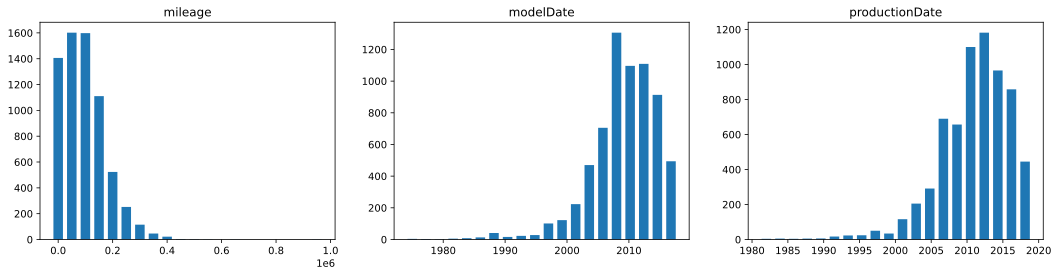

In [21]:
# Посмотрим, как выглядят распределения числовых признаков

def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()


visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Числовые признаки показывают существенное смещение. Для нейронных сетей их придётся нормировать.

In [22]:
# Осмотрим распределение и самые частые категории в категориальных признаках.

for feature in numerical_features:
    print(f'{feature}\n')
    numerical_eda(data, feature)
    print(f'----------\n')

mileage

Переменная mileage:
 count       8353.00
mean      120362.98
std        81856.64
min            1.00
25%        59246.00
50%       110384.00
75%       167084.00
max      1000000.00
Name: mileage, dtype: float64
Кол-во уникальных значений: 3507
Кол-во пропусков: 0
Кол-во выбросов: 161, или 0.02%.
----------

modelDate

Переменная modelDate:
 count    8353.00
mean     2010.10
std         5.44
min      1971.00
25%      2007.00
50%      2011.00
75%      2014.00
max      2019.00
Name: modelDate, dtype: float64
Кол-во уникальных значений: 43
Кол-во пропусков: 0
Кол-во выбросов: 191, или 0.02%.
----------

productionDate

Переменная productionDate:
 count    8353.00
mean     2012.01
std         5.11
min      1982.00
25%      2009.00
50%      2013.00
75%      2016.00
max      2020.00
Name: productionDate, dtype: float64
Кол-во уникальных значений: 39
Кол-во пропусков: 0
Кол-во выбросов: 144, или 0.02%.
----------



### Feature Engineering - Создание дополнительных признаков

In [23]:
# Создадим признак популярных и не очень цветов

def color_cat(color):
    
    if color in ['чёрный', 'белый']:
        return 'популярный цвет'
    elif color in ['синий', 'серый', 'коричневый', 'серебристый']:
        return 'частый цвет'
    else:
        return 'редкий цвет'

In [24]:
# Создадим признак приблизительного поколения машины

def generation_cat(modelDate):
    
    if modelDate < 1975:
        return 'раритет'
    elif modelDate >= 1975 and modelDate <= 1982:
        return 'первое'
    elif modelDate >= 1983 and modelDate <= 1992:
        return 'второе'
    elif modelDate >= 1993 and modelDate <= 1999:
        return 'третье'
    elif modelDate >= 2000 and modelDate <= 2006:
        return 'четвёртое'
    elif modelDate >= 2007 and modelDate <= 2012:
        return 'пятое'
    elif modelDate >= 2013 and modelDate <= 2018:
        return 'шестое'
    else:
        return 'седьмое'

In [25]:
# Создадим категориальный признак на основе пробега машины

def mileage_cat(mileage):
    
    if mileage <= 100:
        return 'новая'
    elif mileage > 100 and mileage <= 10000:
        return 'почти новая'
    elif mileage > 10000 and mileage <= 50000:
        return 'умеренный пробег'
    elif mileage > 50000 and mileage <= 150000:
        return 'подержаная'
    elif mileage > 150000 and mileage <= 300000:
        return 'старая'
    else:
        return 'очень старая'

In [26]:
# Ф-ия для перевода кол-ва владельцев в целочисленный тип

def owners_count(owners):
    
    pattern = re.compile('\d+')

    try:
        return int(pattern.search(owners)[0])

    except:
        return None

In [27]:
def preproc_data(df_input):
    '''
    Функция для предобработки данных.
    '''
    
    df_output = df_input.copy()
    

    # ################### 1. Категориальные признаки ####################################################
    
    # Владение - меняем формат данных на кол-во месяцев и заполняем пропуски средним значением по году производства
    df_output['Владение'] = df_output['Владение'].apply(ownership_to_months)
    
    avg_by_prodDate = df_output.groupby(['productionDate'])['Владение'].mean().round().to_dict()
    df_output['avg_by_prodDate'] = df_output['productionDate'].replace(avg_by_prodDate)

    # Владение - для раритетов, где нет подходящего значения дополним общим средним за весь датасет
    df_output['avg_by_prodDate'].fillna(round(df_output['Владение'].mean()), inplace=True)

    # Владение - заполним отсутствующие значения соответственными средними из новой колонки
    df_output['Владение'].fillna(df_output['avg_by_prodDate'], inplace=True)
    
    
    # Оба наблюдения с правым рулём в тренировочном наборе, можно удалить без ущерба
    df_output = df_output[df_output['Руль'] != 'Правый']

    
    # engineDisplacement - уберём в тесте суффикс ' LTR'
    df_output['engineDisplacement'] = df_output['engineDisplacement'].apply(lambda x: x.replace(' LTR', '') if isinstance(x, str) else x)

    # Приведём все значения к формату числа с плавающей точкой (неопределённые значения будут конвертированы в NaN)
    df_output['engineDisplacement'] = pd.to_numeric(df_output['engineDisplacement'], errors='coerce')


    # enginePower - уберём в тесте суффикс ' N12'
    df_output['enginePower'] = df_output['enginePower'].apply(lambda x: x.replace(' N12', '') if isinstance(x, str) else x)

    # Приведём все значения к формату числа с плавающей точкой (неопределённые значения будут конвертированы в NaN)
    df_output['enginePower'] = pd.to_numeric(df_output['enginePower'], errors='coerce')


    # Заполним пропуск и переведём в целочисленный тип (кол-во предыдущих владельцев)
    df_output['Владельцы'].fillna('1 владелец', inplace=True)    
    df_output['Владельцы'] = df_output['Владельцы'].apply(owners_count).astype('int')


    
    # ################### 2. Feature Engineering ######################################################
    
    df_output['color_cat'] = df_output['color'].apply(color_cat)                        # Категория цвета
    df_output['generation_cat'] = df_output['modelDate'].apply(generation_cat)          # "Поколение" машины
    df_output['mileage_cat'] = df_output['mileage'].apply(mileage_cat)                  # Категория пробега


    # Создадим признак среднего пробега в год
    current_year = 2021
    df_output['mileage_pa'] = df_output.apply(lambda row: row['mileage'] / (current_year - row['productionDate']) if (current_year - row['productionDate']) > 0 else 0, axis=1)
    
    # Создадим признак длины сопутствующего описания
    df_output['description_len'] = df_output['description'].apply(lambda x: len(x) if isinstance(x, str) else 0)
    
    # Создадим признак наличия камеры и круиз-контроля в машине
    df_output['camera'] = df_output['description'].apply(lambda x: 1 if (isinstance(x, str) and 'камер' in x) else 0).astype('int32')
    df_output['cruise_control'] = df_output['description'].apply(lambda x: 1 if (isinstance(x, str) and 'круиз' in x) else 0).astype('int32')
    
    
    
    # ################### 3. Числовые признаки ########################################################### 
    
    # Убедимся, что данные в формате числа с плавающей точкой
    df_output['price'] = df_output['price'].astype('float32')
    
    
    # Логарифмируем признаки для лучшей обработки НС
    
    df_output['engineDisplacement_log'] = np.log(df_output['engineDisplacement'] + 1)
    df_output['enginePower_log'] = np.log(df_output['enginePower'] + 1)
    df_output['mileage_log'] = np.log(df_output['mileage'] + 1)
    df_output['modelDate_log'] = np.log(current_year - data['modelDate'])
    df_output['productionDate_log'] = np.log(current_year - data['productionDate'])
    df_output['Владение_log'] = np.log(df_output['Владение'] + 1)
    
    
    
    # ################### 4. Дополнительная обработка ############################################################## 
    
    # Убираем избыточные признаки
    df_output.drop(['description', 'sell_id', 'Руль', 'vehicleConfiguration', 'description', 'name'], axis=1, inplace=True)
    
    
    # Обновим списки категориальных и числовых признаков (также исключим цену и тип набора)
    categorical_features = list(df_output.select_dtypes('object').columns)
    
    numerical_features = list(df_output.columns[~df_output.columns.isin(categorical_features + ['price', 'sample'])])


    # Заполним оставшиеся пропуски медианой
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)

    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
    
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, prefix=categorical_features, columns=categorical_features, dummy_na=False)
    
    
    return df_output

In [28]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,Владельцы,Владение,sample,price,...,generation_cat_4,generation_cat_5,generation_cat_6,generation_cat_7,mileage_cat_0,mileage_cat_1,mileage_cat_2,mileage_cat_3,mileage_cat_4,mileage_cat_5
2461,0.220339,0.1744,0.030807,0.916667,1.000000,0.973684,0.0,0.025424,1,3269399.0,...,0,0,0,1,0,0,0,0,0,1
5592,0.627119,0.6000,0.055999,0.854167,0.666667,0.842105,0.5,0.127119,1,2100000.0,...,0,0,0,0,0,0,1,0,0,0
4929,0.220339,0.1680,0.045999,0.895833,1.000000,0.868421,1.0,0.059322,1,1580000.0,...,0,0,0,1,0,0,0,0,0,1
4771,0.152542,0.0976,0.163999,0.833333,0.666667,0.815789,1.0,0.144068,1,780000.0,...,0,0,0,0,0,0,0,0,1,0
1442,0.389831,0.2528,0.144499,0.750000,0.666667,0.684211,0.0,0.189266,0,0.0,...,0,0,0,0,0,0,1,0,0,0
1034,0.220339,0.2176,0.194999,0.770833,1.000000,0.789474,1.0,0.146893,0,0.0,...,0,0,0,0,0,0,0,0,1,0
7721,0.220339,0.1888,0.174999,0.708333,1.000000,0.657895,0.5,0.048023,1,435000.0,...,0,0,1,0,0,0,0,0,1,0
3705,0.338983,0.2800,0.282059,0.604167,1.000000,0.500000,0.5,0.183616,1,350000.0,...,0,0,1,0,0,0,0,0,1,0
2306,0.186441,0.1296,0.159999,0.833333,0.666667,0.763158,1.0,0.152542,1,880000.0,...,0,0,0,0,0,0,0,0,1,0
855,0.389831,0.2400,0.224887,0.687500,0.666667,0.605263,1.0,0.073446,0,0.0,...,0,0,1,0,0,0,0,0,1,0


In [29]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8351 entries, 0 to 8352
Columns: 209 entries, engineDisplacement to mileage_cat_5
dtypes: float32(1), float64(19), int64(1), uint8(188)
memory usage: 2.9 MB


### Разбиваем данные

In [30]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [31]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 208 entries, engineDisplacement to mileage_cat_5
dtypes: float32(1), float64(19), uint8(188)
memory usage: 574.4 KB


---
## 5. Модель №2 - CatBoostRegressor

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [33]:
model = CatBoostRegressor(iterations=5000,
                          learning_rate=0.1,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500
)

model.fit(X_train,
          y_train,
          eval_set=(X_test, y_test),
          verbose_eval=500,
          use_best_model=True
)

0:	learn: 0.9205323	test: 0.9168431	best: 0.9168431 (0)	total: 59.1ms	remaining: 4m 55s
500:	learn: 0.1113089	test: 0.1418680	best: 0.1418680 (500)	total: 2.93s	remaining: 26.3s
1000:	learn: 0.0905453	test: 0.1370308	best: 0.1369861 (999)	total: 5.48s	remaining: 21.9s
1500:	learn: 0.0767487	test: 0.1346771	best: 0.1346771 (1500)	total: 7.83s	remaining: 18.2s
2000:	learn: 0.0664154	test: 0.1336794	best: 0.1335992 (1958)	total: 10.8s	remaining: 16.3s
2500:	learn: 0.0575852	test: 0.1332121	best: 0.1331264 (2406)	total: 13.9s	remaining: 13.9s
3000:	learn: 0.0499959	test: 0.1335182	best: 0.1329919 (2705)	total: 16.5s	remaining: 11s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.1329919338
bestIteration = 2705

Shrink model to first 2706 iterations.


In [34]:
test_predict_catboost = model.predict(X_test)
print(f"MAPE: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

MAPE: 13.30%


### Submission

In [35]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

---
## 6. Модель №3 - Базовая нейронная сеть

In [36]:
K.clear_session()

model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu", bias_regularizer=regularizers.l2(1e-4)))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               106496    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 238,081
Trainable params: 238,081
Non-trainable params: 0
_________________________________________________________________


In [37]:
optimizer = tf.keras.optimizers.Adam(0.01)

model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [38]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5',
                             monitor=['val_MAPE'],
                             verbose=0,
                             mode='min'
)

earlystop = EarlyStopping(monitor='val_MAPE',
                          patience=50,
                          restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
                            monitor='val_MAPE',
                            factor=0.25,
                            patience=50,
                            min_lr=0.0000001,
                            verbose=0,
                            mode='auto'
)

callbacks_list = [checkpoint, earlystop, reduce_lr]

In [39]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0
)

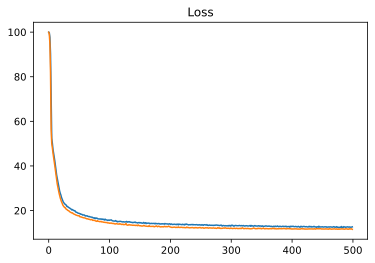

In [40]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [41]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [42]:
test_predict_nn1 = model.predict(X_test)
print(f"MAPE: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

MAPE: 11.60%


In [43]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

---
## 7. Модель №4 - NLP и Multiple Inputs

In [44]:
# Выборка описаний

data['description'].sample(5)

4104    РОЛЬФ Премиум – крупнейший официальный дилер М...
4049    РОЛЬФ Премиум – крупнейший официальный дилер М...
6886    Состояние автомобиля идеальное,покупал новым в...
7948    Конец 2013 года, 170 сил!, с монитором, компле...
4566    Гарантированная СКИДКА до 100 000 рублей на КА...
Name: description, dtype: object

In [45]:
# Приведём слова к их начальной форме ("лемматизация")
morph = pymorphy2.MorphAnalyzer()
df_NLP = data.copy()

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"


def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    
    for token in doc.split():
        token = token.strip()
        token = morph.normal_forms(token)[0]
        
        if len(token) > 2:              # избавимся от сокращений и посторонних символов
            tokens.append(token)
        
    return ' '.join(tokens)


df_NLP['description'] = df_NLP['description'].apply(lemmatize)

In [46]:
# split данных
text_train = df_NLP['description'].iloc[X_train.index]
text_test = df_NLP['description'].iloc[X_test.index]
text_sub = df_NLP['description'].iloc[X_sub.index]

### Tokenizer

In [47]:
# TOKENIZER
# The maximum number of words to be used (most frequent)
MAX_WORDS = 100000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [48]:
tokenize = Tokenizer(num_words=MAX_WORDS)

tokenize.fit_on_texts(df_NLP['description'])

tokenize.word_index

{'автомобиль': 1,
 'система': 2,
 'всё': 3,
 'пробег': 4,
 'задний': 5,
 'салон': 6,
 'сидение': 7,
 'год': 8,
 'состояние': 9,
 'для': 10,
 'передний': 11,
 'машина': 12,
 'при': 13,
 'диск': 14,
 'комплект': 15,
 'дилер': 16,
 'новый': 17,
 'официальный': 18,
 'без': 19,
 'ваш': 20,
 'кредит': 21,
 'фара': 22,
 'авто': 23,
 'быть': 24,
 'руль': 25,
 'пакет': 26,
 'колесо': 27,
 'безопасность': 28,
 'комплектация': 29,
 'гарантия': 30,
 'птс': 31,
 'обмен': 32,
 'контроль': 33,
 'зеркало': 34,
 'проверка': 35,
 'покупка': 36,
 'весь': 37,
 'два': 38,
 'продажа': 39,
 'водитель': 40,
 'более': 41,
 'полный': 42,
 'есть': 43,
 'шина': 44,
 'датчик': 45,
 'отличный': 46,
 'пассажир': 47,
 'двигатель': 48,
 'так': 49,
 'резина': 50,
 'условие': 51,
 'владелец': 52,
 'только': 53,
 'ключ': 54,
 'один': 55,
 'хороший': 56,
 'кузов': 57,
 'подушка': 58,
 'подогрев': 59,
 'технический': 60,
 'любой': 61,
 'обслуживание': 62,
 'обогрев': 63,
 'юридический': 64,
 'оригинал': 65,
 'стекло': 66,


In [49]:
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train),
                                              maxlen=MAX_SEQUENCE_LENGTH
)

text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test),
                                             maxlen=MAX_SEQUENCE_LENGTH
)

text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub),
                                            maxlen=MAX_SEQUENCE_LENGTH
)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape)

(5678, 256) (1002, 256) (1671, 256)


In [50]:
# Наш текст после всех изменений

print(text_train.iloc[6])

print(text_train_sequences[6])

официальный дилер ооо «рольф» филиал «звезда столица варшавка» автокредит два документ одобрение час специальный условие при обмен ваш автомобиль наличие более автомобиль пробег всё автомобиль пройти комплексный диагностик гарантия юридический чистота более комплект колесо шина пробег выгодный цена широкий ассортимент дополнительный оборудование кредитный ставка зависеть параметр автомобиль срок кредитование страхование размер первоначальный взнос более проверить автомобиль пробег гарантия год ждать сайт мобильный приложение мой рольф
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0   

### RNN NLP

In [51]:
K.clear_session()

model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [52]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [53]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])

head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     3563520     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

In [54]:
optimizer = tf.keras.optimizers.Adam(0.01)

model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [55]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5',
                             monitor=['val_MAPE'],
                             verbose=0,
                             mode='min'
)

earlystop = EarlyStopping(monitor='val_MAPE',
                          patience=10,
                          restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
                            monitor='val_MAPE',
                            factor=0.25,
                            patience=10,
                            min_lr=0.0000001,
                            verbose=0,
                            mode='auto'
)

callbacks_list = [checkpoint, earlystop, reduce_lr]

In [56]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
)

Epoch 1/500
12/12 [==============================] - 4s 307ms/step - loss: 99.9751 - MAPE: 99.9751 - val_loss: 99.7074 - val_MAPE: 99.7074
Epoch 2/500
12/12 [==============================] - 3s 228ms/step - loss: 97.4135 - MAPE: 97.4135 - val_loss: 88.6809 - val_MAPE: 88.6809
Epoch 3/500
12/12 [==============================] - 3s 230ms/step - loss: 68.2600 - MAPE: 68.2600 - val_loss: 53.0039 - val_MAPE: 53.0039
Epoch 4/500
12/12 [==============================] - 3s 225ms/step - loss: 51.9021 - MAPE: 51.9021 - val_loss: 47.5416 - val_MAPE: 47.5416
Epoch 5/500
12/12 [==============================] - 3s 229ms/step - loss: 46.6864 - MAPE: 46.6864 - val_loss: 42.7964 - val_MAPE: 42.7964
Epoch 6/500
12/12 [==============================] - 3s 227ms/step - loss: 41.7628 - MAPE: 41.7628 - val_loss: 38.5915 - val_MAPE: 38.5915
Epoch 7/500
12/12 [==============================] - 3s 238ms/step - loss: 37.4112 - MAPE: 37.4112 - val_loss: 33.5781 - val_MAPE: 33.5781
Epoch 8/500
12/12 [========

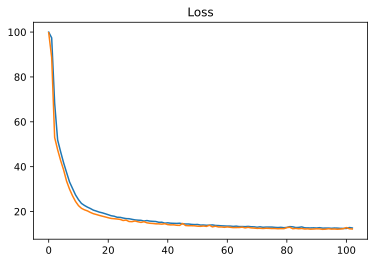

In [57]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [58]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [59]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"MAPE: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

MAPE: 12.21%


In [60]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

---
## 8. Модель №5 - NLP + обработка изображений

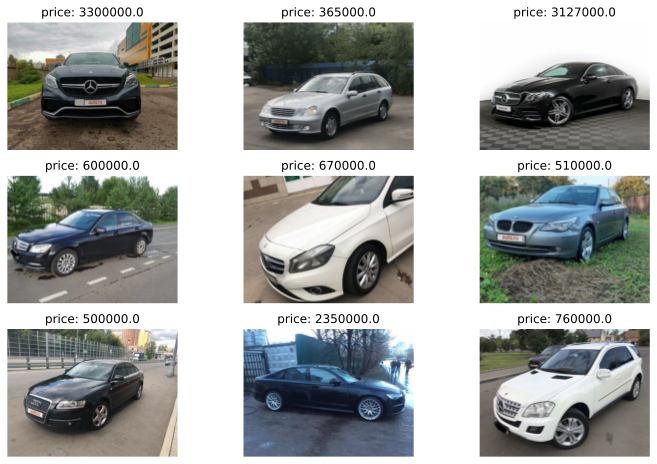

In [61]:
# Убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [62]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5678, 240, 320, 3) dtype uint8
images shape (1002, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### Создание обогащённой базы изображений с помощью Albumentations

In [63]:
def make_augmentations(images):
    '''
        Функция, применяющая искажения к изображению, поданному на вход.
    '''
    
    print('применение аугментаций', end = '')
    
    augmented_images = np.empty(images.shape)
    
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
            
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
    
    print('')
    
    return augmented_images

In [64]:
# Настройка параметров по документации:
# https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

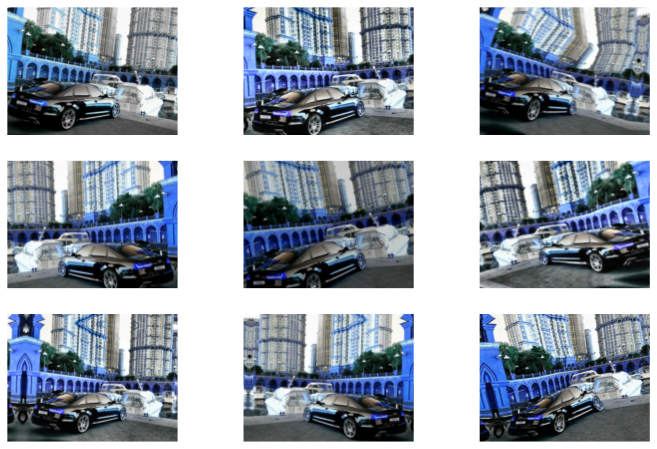

In [65]:
# Пример полученного изображения

plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [66]:
# NLP-часть

tokenize = Tokenizer(num_words=MAX_WORDS)

tokenize.fit_on_texts(df_NLP['description'])

In [67]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions),
                                  maxlen = MAX_SEQUENCE_LENGTH
    )

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)


# Проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [68]:
K.clear_session()

efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights='imagenet',
                                                                       include_top=False,
                                                                       input_shape=(size[1], size[0], 3)
)

efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)
efficientnet_output = L.Dense(256, activation='relu', bias_regularizer=regularizers.l2(1e-4))(efficientnet_output)
efficientnet_output = L.BatchNormalization()(efficientnet_output)
efficientnet_output = L.Dropout(0.25)(efficientnet_output)

43941888/43941136 [==============================] - 0s 0us/step


In [69]:
# Доводка (fine-tuning) с половиной весов.

fine_tune_at = len(efficientnet_model.layers)//2

for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [70]:
# Нейросеть для анализа табличных данных

tabular_model = Sequential([L.Input(shape=X.shape[1]),
                            L.Dense(512, activation='relu'),
                            L.Dropout(0.5),
                            L.Dense(256, activation='relu'),
                            L.Dropout(0.5)]
)

In [71]:
# NLP

nlp_model = Sequential([L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
                        L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH),
                        L.LSTM(256, return_sequences=True),
                        L.Dropout(0.5),
                        L.LSTM(128),
                        L.Dropout(0.25),
                        L.Dense(64)]
)

In [72]:
# Объединяем выходы трех нейросетей

combinedInput = L.concatenate([efficientnet_output,
                               tabular_model.output,
                               nlp_model.output]
)


head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input,
                      tabular_model.input,
                      nlp_model.input],
              outputs=head
)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [73]:
optimizer = tf.keras.optimizers.Adam(0.005)

model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [74]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5',
                             monitor=['val_MAPE'],
                             verbose=0,
                             mode='min'
)

earlystop = EarlyStopping(monitor='val_MAPE',
                          patience=10,
                          restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
                            monitor='val_MAPE',
                            factor=0.25,
                            patience=10,
                            min_lr=0.0000001,
                            verbose=0,
                            mode='auto'
)

callbacks_list = [checkpoint, earlystop, reduce_lr]

In [75]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data=test_dataset.batch(30),
                    callbacks=callbacks_list
)

Epoch 1/100
190/190 [==============================] - 91s 478ms/step - loss: 51.3027 - MAPE: 51.3027 - val_loss: 626.9581 - val_MAPE: 626.9581
Epoch 2/100
190/190 [==============================] - 87s 460ms/step - loss: 24.1189 - MAPE: 24.1189 - val_loss: 20.4546 - val_MAPE: 20.4546
Epoch 3/100
190/190 [==============================] - 86s 454ms/step - loss: 20.9076 - MAPE: 20.9076 - val_loss: 19.3185 - val_MAPE: 19.3185
Epoch 4/100
190/190 [==============================] - 88s 462ms/step - loss: 19.0359 - MAPE: 19.0359 - val_loss: 16.8858 - val_MAPE: 16.8858
Epoch 5/100
190/190 [==============================] - 86s 451ms/step - loss: 17.4485 - MAPE: 17.4485 - val_loss: 15.7804 - val_MAPE: 15.7804
Epoch 6/100
190/190 [==============================] - 91s 477ms/step - loss: 16.6217 - MAPE: 16.6217 - val_loss: 15.2010 - val_MAPE: 15.2009
Epoch 7/100
190/190 [==============================] - 88s 464ms/step - loss: 15.9789 - MAPE: 15.9789 - val_loss: 14.5741 - val_MAPE: 14.5741
Epoc

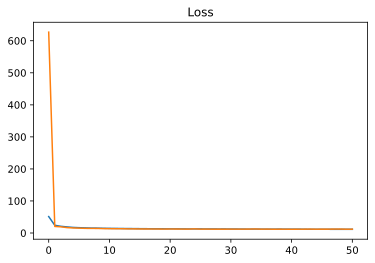

In [76]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [77]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [78]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"MAPE: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

MAPE: 11.94%


In [79]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

---
## 9. Модель №6 - Многослойный перцептрон с пробросом признака

In [80]:
K.clear_session()

model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu", bias_regularizer=regularizers.l2(1e-4)))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [81]:
# Признаки для проброса - год производства и кол-во владельцев

productiondate = L.Input(shape=[1],
                         name='productionDate'
)

emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)


owners = L.Input(shape=[1],
                 name='Owners'
)

emb_owners = L.Embedding(len(X['Владельцы'].unique().tolist())+1, 20)(owners)
f_owners = L.Flatten()(emb_owners)

In [82]:
combinedInput = L.concatenate([model_mlp.output,
                               f_productiondate,
                               f_owners]
)

head = L.Dense(128, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input,
                      productiondate,
                      owners],
              outputs=head
)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_input (InputLayer)        [(None, 207)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          106496      dense_input[0][0]                
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512)          0           dense[0][0]                      
__________________________________________________________________________________________________
productionDate (InputLayer)     [(None, 1)]          0                                            
_______________________________________________________________________________________

In [83]:
optimizer = tf.keras.optimizers.Adam(0.01)

model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [84]:
history = model.fit([X_train, X_train['productionDate'].values, X_train['Владельцы'].values],
                    y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test,
                                      X_test['productionDate'].values,
                                      X_test['Владельцы'].values],
                                     y_test
                    ),
                    callbacks=callbacks_list
)

Epoch 1/500
12/12 [==============================] - 0s 24ms/step - loss: 99.9612 - MAPE: 99.9612 - val_loss: 99.5177 - val_MAPE: 99.5175
Epoch 2/500
12/12 [==============================] - 0s 9ms/step - loss: 95.2581 - MAPE: 95.2575 - val_loss: 78.5647 - val_MAPE: 78.5632
Epoch 3/500
12/12 [==============================] - 0s 9ms/step - loss: 60.1478 - MAPE: 60.1453 - val_loss: 54.4305 - val_MAPE: 54.4272
Epoch 4/500
12/12 [==============================] - 0s 10ms/step - loss: 49.2448 - MAPE: 49.2420 - val_loss: 46.0709 - val_MAPE: 46.0684
Epoch 5/500
12/12 [==============================] - 0s 9ms/step - loss: 43.7052 - MAPE: 43.7026 - val_loss: 39.9356 - val_MAPE: 39.9331
Epoch 6/500
12/12 [==============================] - 0s 9ms/step - loss: 38.5000 - MAPE: 38.4979 - val_loss: 34.1612 - val_MAPE: 34.1594
Epoch 7/500
12/12 [==============================] - 0s 10ms/step - loss: 33.7105 - MAPE: 33.7090 - val_loss: 30.2439 - val_MAPE: 30.2426
Epoch 8/500
12/12 [===================

In [85]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_passthru.hdf5')

In [86]:
test_predict_nn_bonus = model.predict([X_test,
                                       X_test['productionDate'].values,
                                       X_test['mileage'].values]
)

print(f"MAPE: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

MAPE: 11.76%


In [87]:
sub_predict_nn4 = model.predict([X_sub, X_sub['productionDate'].values, X_sub['mileage'].values])
sample_submission['price'] = sub_predict_nn4[:,0]
sample_submission.to_csv('nn4_submission.csv', index=False)

---
## 10. Усреднённое предсказание

Усредним показания лучшей модели НС и CatBoost-а, чтобы получить "оптимальный" прогноз цены.

In [88]:
blend_predict = np.round((test_predict_catboost + test_predict_nn3[:,0]) / 2 / 1000) * 1000
print(f"MAPE: {(mape(y_test, blend_predict))*100:0.2f}%")

MAPE: 11.71%


In [89]:
blend_sub_predict = np.round((sub_predict_catboost + sub_predict_nn3[:,0]) / 2 / 1000) * 1000
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

---
## 11. Итоги и выводы

* Обработка данных (перевод некоторых переменных в численный тип, дополнение пропусков, формат данных, понижение размерности и т.д.) + создание новых фичей ожидаемо помогло улучшить качество модели и снизить время обработки данных.
* "Наивная" модель показала очень неплохой результат. Учитывая время, затраченное на неё, стОит иметь в виду такой вариант, если надо подготовить что-то "ну очень быстро" и нет времени на обучение модели. Также такая модель полезна и в качестве эталона, чтобы сравнить улучшения показателей в более сложных моделях.
* В базовой моделе опять применил L2 регуляризатор на первом полносвязном слое и получил ожидаемый прирост. В результате как ни парадоксально эта модель оказалась самой лучшой по тестовому MAPE и оптимальной по времени обучения из всех!
* Впервые плотно поработал с обработкой естественного языка с библиотекой pymorphy2. Относительно небольшие затраты по обработке и лемматизации текста вернулись сторицей - комбинированая сеть NLP и многослойного перцептрона показала на тесте достаточно хороший результат. Хотя по сравнению с "базовой" НС показатель MAPE просел.
* Что удивило, так это то, что комбинированная модель NLP и изображений показала хуже результат, чем базовая, а времени на обработку и обучение ушло бОльше. Опять применил Albumenations, но, как и в предыдущем проекте №7 это вопреки ожиданиям не дало улучшений, хоть на этот раз использовал другой набор гиперпараметров (пробовал несколько вариантов).
* Не заметил особой разницы при применении доводки (fine-tuning), когда EfficientNet обучал только на половине исходных весов.
* В комбинированной модели также усложнил архитектуру НС (добавил полносвязный слой, батч-нормализацию и дропаут) и поигрался с callback-настройкой скорости обучения (learning rate).
* Многослойный перцептрон с пробросом признака дал лучший результат, чем CatBoost, но хуже, чем базовая модель без проброса признака. Добавление второго признака (сначала пробега, а потом и кол-ва бывших владельцев) особого улучшения не принесло.
* Загадкой для меня остался вопрос почему в данной модели MAPE существенно просел после добавления батч-нормализации.
* Результаты MAPE последнего прогона всех моделей:
    * Наивная - 19,88%
    * CatBoost - 13,3%
    * Простая НС - 11,6%
    * RNN NLP + MLP - 12.21%
    * NLP + изображения - 11.94%
    * MLP с пробросом 2 признаков - 11.76%
    * Усреднённое + округление - 11.71%